In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm # Colormaps
import matplotlib.gridspec as gridspec
import scipy.spatial


# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
np.random.seed(seed=1)

* http://www.cs.ubc.ca/~nando/540-2013/lectures.html
* https://www.youtube.com/watch?v=w2OtwL5T1ow&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6
* http://videolectures.net/gpip06_mackay_gpb/
* http://www.robots.ox.ac.uk/~mebden/reports/GPtutorial.pdf
* http://www.gaussianprocess.org/gpml/chapters/RW2.pdf
* https://en.wikipedia.org/wiki/Schur_complement#Schur_complement_condition_for_positive_definiteness
* http://blog.sigopt.com/post/130275376068/sigopt-fundamentals-intuition-behind-gaussian
* http://learning.eng.cam.ac.uk/carl/talks/gpnt06.pdf
* http://blog.sigopt.com/post/134931842613/sigopt-fundamentals-likelihood-for-gaussian
* http://blog.sigopt.com/post/134931028143/sigopt-in-depth-profile-likelihood-vs-kriging
* http://dan.iel.fm/george/current/user/hyper/
* http://scikit-learn.org/dev/auto_examples/gaussian_process/plot_gpr_co2.html

What are Gaussian processes? The name implies that its a stochastic process of random variables with a Gaussian distribution. This might not mean much at this point so lets dig a bit deeper in its meaning:


## Stochastic process

A [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process) process is also known as random process. In a stochastic process there is some uncertainty: even if the starting point is known, there are several directions in which the process can evolve.

An example of a stochastic process that you might have come across is the model of [Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion) (also known as [Wiener process](https://en.wikipedia.org/wiki/Wiener_process). Brownian motion is the random motion of particles suspended in a fluid. It can be seen as kind of a random walk where a particle moves around in the fluid due to other particles randomly bumping into it. We can simulate this process over time in 1 dimension by starting out at position 0 and move the particle over a certain amount of time $dt$ with a random distance from the previous position. The random distance is sampled from a normal distribution with mean $0$ and standard deviation $\sqrt{dt}$ ($\mathcal{N}(0, \sqrt{dt})$). We simulate 5 different paths in the following figure.

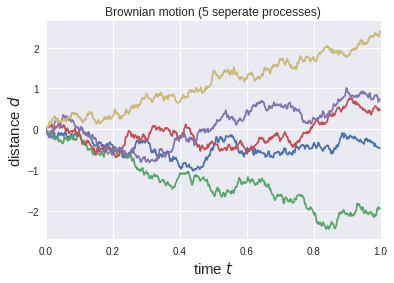

In [32]:
total_time = 1
nb_steps = 500
dt = total_time / nb_steps
nb_processes = 5  # Simulate 5 different motions
mean = 0.  # Mean of each movement
stdev = np.sqrt(dt)  # Standard deviation of each movement

# Simulate the brownian motions in a 1D space
distances = np.zeros((nb_processes, nb_steps))
for i in range(1, N):
    # Move randomly from current location to N(0, sqrt(dt))
    distances[:,i] = distances[:,i-1] + np.random.normal(mean, stdev, nb_processes)

# Make the plots
t = np.arange(0, total_time, step_size)
for i in range(nb_processes):
    plt.plot(t, distances[i,:])
plt.title('Brownian motion (5 seperate processes)')
plt.xlabel('time $t$', fontsize=15)
plt.ylabel('distance $d$', fontsize=15)
plt.xlim([-0, 1])
plt.show()

Notice in the figure above that the stochastic process can lead to different motion paths (or [realisations](https://en.wikipedia.org/wiki/Realization_%28probability%29) of the process). Each realisation defines a distance $d$ from the origin for every possible timestep $t$. Every realisation thus corresponds to a function $f(t) = d$.

This means that a stochastic process is a random distribution over functions. We can sample specific realisations of a function from a stochastic process. Gaussian processes are stochastic processes with a specific distribution. In fact we will later show that our Brownian motion example falls under the category of Gaussian processes [TODO: refer].

## Gaussian stochastic process

## Gaussian process

TODO: "Definition: a Gaussian process is a collection of random variables, any
finite number of which have (consistent) Gaussian distributions."

"A Gaussian distribution is fully specified by a mean vector, µ, and covariance
matrix Σ:"

"A Gaussian process is fully specified by a mean function m(x) and covariance
function k(x✱ x0):"
http://learning.eng.cam.ac.uk/carl/talks/gpnt06.pdf



A [Gaussian process](https://en.wikipedia.org/wiki/Gaussian_process) (GP) is a distribution $p(f)$ over functions $f(\mathbf{x})=y$. A function can be thought of as a infinite vector where each element corresponds to a function value $f(\mathbf{x})=y$ at a specific input $\mathbf{x}$.
A Gaussian process is defined so that it associates a Gaussian distributed random variable (TODO: intermezzo) $y$ for every point in the input space $\mathbf{x} \in \mathbb{R}^D$ such that any finite subset $(y_1 ... y_n)$ of these random variables is a joint Gaussian distribution (TODO: intermezzo). Since the GP defines a variable $y$ for every point $\mathbf{x}$ it is a distribution of functions $f(\mathbf{x})$. A Gaussian process model is completely specified by its mean and covariance (TODO: intermezzo) functions:

$$p(f) = \mathcal{GP}(m(X),C(X,X)), \quad f:\mathbb{R}^d \rightarrow \mathbb{R}$$

With $p(f)$ the distribution of $f$ and $X$ the data with dimension $d$. The mean $m(X)$ and covariance $C(X,X)$ are a function of $X$: (TODO: link to intermezzo)

$$m(X) = \mathbb{E}[f(X)]$$

$$C(X,X') = \mathbb{E}[(f(X)-m(X))(f(X')-m(X'))] $$

Note that the mean of the outputs and the covariance between the outputs are written as functions of the inputs.

## Kernel function

The [covariance](https://en.wikipedia.org/wiki/Covariance_function) can be modelled by a [kernel](https://en.wikipedia.org/wiki/Positive-definite_kernel) function $K(X,Y)$ that models how much the samples from $X$ and $Y$ change together. $K(X,Y)$ is positive if there is some similarity between the samples and will be zero if the samples are completely independent.

### Radial basis function kernel
A popular kernel is the [radial basis function](https://en.wikipedia.org/wiki/Radial_basis_function_kernel) (RBF) kernel: 

$$K(X,Y) = e^{\textstyle \left( -\frac{1}{2\sigma^2} \lVert X-Y \rVert^2 \right)} $$

TODO: Multidimensional?

This kernel is illustrated in the next figure which shows the distance with respect to $0$: $K(0,y)$. Note that the similarity outputted by the kernel decreases exponentially towards $0$ the farther we move move away from the center, and that the similarity is maximum at the center $\mathbf{x}=\mathbf{y}$. Also note that the parameter $\sigma$ (width) defines how fast the similarity decreases. This means that the output of the RBF kernel function $K(\mathbf{x},\mathbf{y})$ is a similarity based on how close $\mathbf{x}$ lies to $\mathbf{y}$, the greater $\sigma$ is, the greater this distance effect.

### Prior
The specification of this covariance function implies a distribution over functions $f(X)$. By choosing a specific kernel function $K$ it possible to set some [prior](https://en.wikipedia.org/wiki/Prior_probability) information on this distribution. For example the RBF kernel captures the prior information that the data lies in a [smooth](https://en.wikipedia.org/wiki/Smoothness) space. This is because it is infinitely differentiable over its full range. I will illustrate this more later in this tutorial.

### Valid kernels
In order to be a valid kernel function the resulting kernel matrix should be [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix). Which means that the matrix should be [symmetric](https://en.wikipedia.org/wiki/Symmetric_matrix) since $K(\mathbf{x},\mathbf{y}) = K(\mathbf{y},\mathbf{x})$, and that the output of the kernel function should be positive ($K(\mathbf{x},\mathbf{y}) \geq 0$). Being positive definite also means that the kernel matrix is [invertable](https://en.wikipedia.org/wiki/Invertible_matrix).

In [2]:
# Define the RBF kernel
def rbf_kernel(x, y, width):
    """Radial Basis Function (RBF) kernel"""
    sqNorm = np.square(x) + np.square(y).T - 2*np.dot(x, y.T)  # (a-b)^2 = a^2 + b^2 - 2ab
    return np.exp(-(1.0/(2*width**2) * sqNorm))

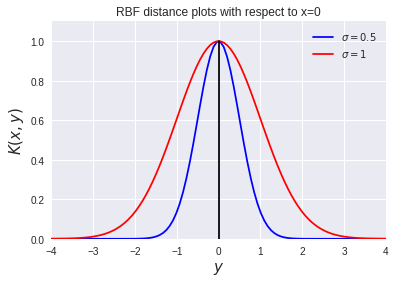

In [3]:
# Plot some kernel values of y with respect to 0
x = np.linspace(-4, 4, num=100)
zero = np.matrix([[0]])
y1 = [rbf_kernel(zero, np.matrix([[xi]]), 0.5)[0,0] for xi in x]
y2 = [rbf_kernel(zero, np.matrix([[xi]]), 1)[0,0] for xi in x]
# Make the plots
plt.plot(x, y1, 'b-', label="$\sigma=0.5$")
plt.plot(x, y2, 'r-', label="$\sigma=1$")
plt.plot((0, 0), (0, 1), 'k-')
plt.xlabel('$y$', fontsize=15)
plt.ylabel('$K(x,y)$', fontsize=15)
plt.title('RBF distance plots with respect to x=0')
plt.ylim([0, 1.1])
plt.xlim([-4, 4])
plt.legend(loc=1)
plt.show()

Cholesky decomposition requires your matrix to be positive definite. If your matrix supposed to be positive definite, you can add a small jitter (e.g. 10−5) to the diagonal of the matrix until it becomes a positive definite matrix. If your derivation is
wrong, then don’t bother it.
http://home.in.tum.de/~xiaoh/emmemo.pdf

The specification of this covariance function implies a distribution over functions $f(X)$. By choosing a specific kernel function $K$ it possible to set some prior information on this distribution.


### Sampling from prior:

The modelling of the covariance function as a kernel function implies a prior distribution over functions. It is possible to sample from this prior at any number of points.  
To sample from a prior with mean $m(\mathbf{x})=0$ and kernel $K(\mathbf{x},\mathbf{x})$ we can pick a number of input points $X$ and create the corresponding covariance matrix defined by  $K(X,X)=K$). Since $f(X)=\mathbf{y}$ is a random Guassian vector we can sample $\mathbf{y}$ from $\mathbf{y} \sim \mathcal{N}(0,K)$

#### Sample from multivariate Gaussian distribution

The intermezzo (TODO: link) shows us how we can sample form this multivariate Gaussian distribution with the help of the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) $K = L * L^\top$.  
We can sample from the standart normal distribution $Z \sim \mathcal{N}(0, I_d)$ and transform the results with $L$:

$$\mathbf{y} \sim L\mathcal{N}(0,I_d)$$ 

We illustrate this below by sampling at discrete points from $\mathcal{N}(0,I_d)$ with [`np.random.normal`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html) and taking the dot product of this with $L$. We sample discrete points from 5 functions, each function in a different color. Note that each of them is quite smooth since the RBF kernel function acts as a smoothness prior.

Note: It might be needed to add some [jitter](https://en.wikipedia.org/wiki/Tikhonov_regularization) to the kernel to ensure it is positive definite in order to do the Cholesky decomposition. The kernel matrix should be [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix), but might not be because of numerical [precision](https://en.wikipedia.org/wiki/Precision_(computer_science%29).

In [4]:
# Sample from the prior
nb_of_samples = 75  # number of test points.
X = np.matrix(np.linspace(-4, 4, nb_of_samples)).T  # Sample from standard normal
K = rbf_kernel(X, X, width=1)  # Kernel of data points

# Draw samples from the prior at our data points.
L = np.linalg.cholesky(K + 1e-14 * np.eye(nb_of_samples))
y_prior = L.dot(np.random.normal(size=(nb_of_samples,5)))

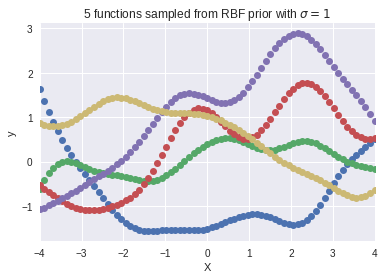

In [5]:
# Plot the sampled functions
plt.plot(X, y_prior, 'o')
plt.xlabel('X')
plt.ylabel('y')
plt.title('5 functions sampled from RBF prior with $\sigma=1$')
plt.xlim([-4, 4])
plt.show()

### RBF kernel as smooth prior

Note that the identity matrix $I$ contains ones on the diagonal and zeros everywhere else. This means that all samples taken from $\mathcal{N}(0,I)$ are independent of eachother and we can just sample each sample seperately. These independent samples are then transformed with the help of the linear transformation $L$ that maps the independent samples to a space where they are more correlated. This correlation is defined by the kernel matrix $K=LL^\top$.  
The next figures illustrate how increasing the width $\sigma$ of the kernel increases it smoothnes.

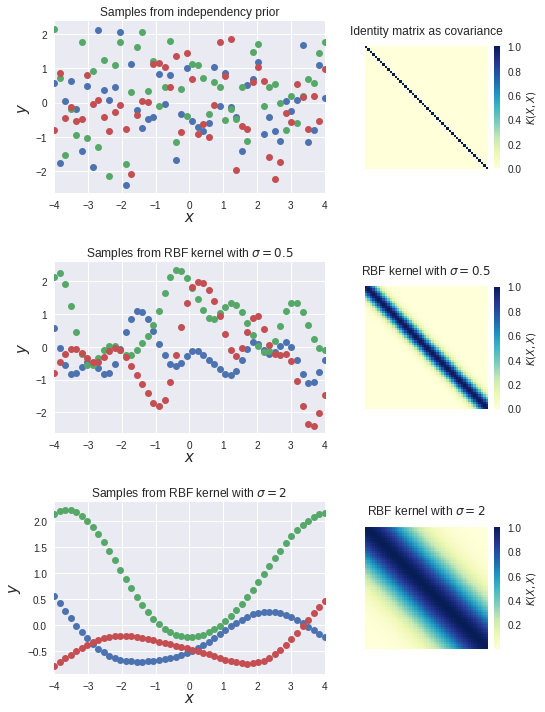

In [6]:
# Show samples from GPs defined by a RBF kernel with different widths
nb_of_samples = 50 # number of test points.
nb_of_functions = 3
# Generate independent samples that can be transformed
X = np.matrix(np.linspace(-4, 4, nb_of_samples)).T
y_independent = np.random.normal(size=(nb_of_samples,nb_of_functions))

fig = plt.figure(figsize=(8, 12)) 
gs0 = gridspec.GridSpec(3, 1)

# Plot no kernel (correlation=0)
# Sample from the prior (no prior)
K_0 = np.eye(nb_of_samples)
L_0 = np.linalg.cholesky(K_0 + 1e-14 * np.eye(nb_of_samples))
y_0 = L_0.dot(y_independent)
# Plot
gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, width_ratios=[2,1], height_ratios=[1], subplot_spec=gs0[0])
# Plot samples
ax1 = plt.subplot(gs00[0])
ax1.plot(X, y_0, 'o')
ax1.set_ylabel('$y$', fontsize=15)
ax1.set_xlabel('$x$', fontsize=15, labelpad=0)
ax1.set_xlim([-4, 4])
ax1.set_title('Samples from independency prior')
# Plot covariance matrix
ax2 = plt.subplot(gs00[1])
im = ax2.matshow(K_0, cmap=cm.YlGnBu)
cbar = plt.colorbar(im, ax=ax2, fraction=0.045, pad=0.05)
cbar.ax.set_ylabel('$K(X,X)$', fontsize=10)
ax2.set_title('Identity matrix as covariance')
ax2.set_frame_on(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)

# Plot RBF with width=0.5
# Sample from the prior
K_05 = rbf_kernel(X, X, width=0.5) # Kernel at test points.
L_05 = np.linalg.cholesky(K_05 + 1e-14 * np.eye(nb_of_samples))
y_05 = L_05.dot(y_independent)
# Plot
gs01 = gridspec.GridSpecFromSubplotSpec(1, 2, width_ratios=[2,1], height_ratios=[1], subplot_spec=gs0[1])
# Plot samples
ax1 = plt.subplot(gs01[0])
ax1.plot(X, y_05, 'o')
ax1.set_ylabel('$y$', fontsize=15)
ax1.set_xlabel('$x$', fontsize=15, labelpad=0)
ax1.set_xlim([-4, 4])
ax1.set_title('Samples from RBF kernel with $\sigma=0.5$')
# Plot covariance matrix
ax2 = plt.subplot(gs01[1])
im = ax2.matshow(K_05, cmap=cm.YlGnBu)
cbar = plt.colorbar(im, ax=ax2, fraction=0.045, pad=0.05)
cbar.ax.set_ylabel('$K(X,X)$', fontsize=10)
ax2.set_title('RBF kernel with $\sigma=0.5$')
ax2.set_frame_on(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)

# Plot RBF with width=2
# Sample from the prior
K_2 = rbf_kernel(X, X, width=2) # Kernel at test points.
L_2 = np.linalg.cholesky(K_2 + 1e-14 * np.eye(nb_of_samples))
y_2 = L_2.dot(y_independent)
# Plot
gs02 = gridspec.GridSpecFromSubplotSpec(1, 2, width_ratios=[2,1], height_ratios=[1], subplot_spec=gs0[2])
# Plot samples
ax1 = plt.subplot(gs02[0])
ax1.plot(X, y_2, 'o')
ax1.set_ylabel('$y$', fontsize=15)
ax1.set_xlabel('$x$', fontsize=15, labelpad=0)
ax1.set_xlim([-4, 4])
ax1.set_title('Samples from RBF kernel with $\sigma=2$')
# Plot covariance matrix
ax2 = plt.subplot(gs02[1])
im = ax2.matshow(K_2, cmap=cm.YlGnBu)
cbar = plt.colorbar(im, ax=ax2, fraction=0.045, pad=0.05)
cbar.ax.set_ylabel('$K(X,X)$', fontsize=10)
ax2.set_title('RBF kernel with $\sigma=2$')
ax2.set_frame_on(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)

gs0.update(wspace=0.0, hspace=0.4) # Adjust spacing between subplots
plt.show()

## Making predictions from data
 
To make predictions $\mathbf{y}_2$ for $n_2$ new samples $X_2$ from  $n_1$ observed data points $(X_1,\mathbf{y}_1)$ ($X_1$ is size $ n_1\times v$)we can sample from the [posterior](https://en.wikipedia.org/wiki/Posterior_probability) distribution $p(\mathbf{y}_2 \mid X_2,X_1,\mathbf{y}_1)$. $\mathbf{y}_1$ and $\mathbf{y}_2$ are jointly Gaussian since they should come both from the same function.  
$X_2$ is size $n_2 \times v$, $\mathbf{y}_2$ is size $n_2 \times 1$, $X_1$ is size $n_1\times v$, and $\mathbf{y}_1$ is size $n_1 \times 1$, with $v$ the number of input variables. We can write:  

$$
\left[\begin{array}{c} \mathbf{y}_{1} \\ \mathbf{y}_{2} \end{array}\right]
\sim
\mathcal{N} \left(
\left[\begin{array}{c} \mu_{1} \\ \mu_{2} \end{array}\right]
\left[ \begin{array}{cc}
K_{11} & K_{12} \\
K_{21} & K_{22}
\end{array} \right]
\right)
$$

Where $\mu_{1}=m(X_1)$, $\mu_{2}=m(X_2)$, $K_{11}=K(X_1,X_1)$, $K_{22}=K(X_2,X_2)$, $K_{12}=K(X_1,X_2)$, and $K_{21}=K(X_2,X_1)$ with $K_{12} = K_{21}^T$. Note that $K_{11}$ is independent of $K_{22}$ and vice versa.
Where:
$$\begin{split}
\mu_{1} & = m(X_1), \quad (n_1 \times 1) \\
\mu_{2} & = m(X_2), \quad (n_2 \times 1) \\
K_{11} & = K(X_1,X_1), \quad (n_1 \times n_1) \\
K_{22} & = K(X_2,X_2), \quad (n_2 \times n_2) \\
K_{12} & = K(X_1,X_2) = K_{21}^\top, \quad (n_1 \times n_2)
\end{split}$$

The intermezzo (TODO: link) explains how we  can get the conditional distribution:

$$\begin{split}
p(y_2 \mid X_2, X_1, y_1) & =  \mathcal{N}(\mu_{2|1}, \Sigma_{2|1}) \\
\mu_{2|1} & = \mu(X_2) + K_{21} K_{11}^{-1} (\mathbf{y}_1 - \mu(X_1)) \\
                    & = K_{21} K_{11}^{-1} \mathbf{y}_1 \quad (\text{assume mean prior }  \mu = 0 ) \\
\Sigma_{2|1} & =  K_{22} - K_{21} K_{11}^{-1}K_{12}
\end{split}$$

It is then possible to sample from this posterior distribution by:

$$\mathbf{y}_{2} \sim L_{21} \mathcal{N}(0,I_d) + \mu_{2|1}$$

Where $\Sigma_{2|1}=L_{21}L_{21}^\top$.

These formula give us a way to sample from the posterior distribution. We can calculate them efficiently with the help of the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition). Note that $K = LL^\top$ means that $K^{-1} = L^{-\top} L^{-1}$. We can then rewrite $\mu_{2|1}$ and $\Sigma_{2|1}$ as:

$$\begin{array}{cc}
\begin{split}
\mu_{2|1} & = K_{21} K_{11}^{-1} \mathbf{y}_1 \\
          & = K_{21} L_{11}^{-\top} L_{11}^{-1} \mathbf{y}_1\\
          & =  (L_{11}^{-1} K_{12})^\top L_{11}^{-1} \mathbf{y}_1\\
          & = \left(\frac{K_{12}}{L_{11}}\right)^\top \frac{\mathbf{y}_1}{L_{11}}
\end{split}
& \qquad
\begin{split}
\Sigma_{2|1} & = K_{22} - K_{21} K_{11}^{-1} K_{12} \\
             & = K_{22} - K_{21} L_{11}^{-\top} L_{11}^{-1} K_{12} \\
             & = K_{22} - (L_{11}^{-1} K_{12})^\top L_{11}^{-1} K_{12} \\
             & = K_{22} - \left(\frac{K_{12}}{L_{11}}\right)^\top \frac{K_{12}}{L_{11}}
\end{split}
\end{array}{c}$$

Note that this means that we dont need to calculate the inverse of $K_{11}$ explicitly. We can replace it's occurence in the computation by a combination of $K_{12}/L_{11}$ and some other computations. Note that we can use the [`numpy.linalg.solve`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html) method to solve the matrix division. Using this method [improves](http://www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix/) the speed and numerical stability.

It is then possible to predict the $\mathbf{y}_2$ corresponding to the input samples $X_2$ by using the mean $\mu_{2|1}$ of the resulting distribution as a prediction. The variance of these predictions is then the diagonal of the covariance matrix $\Sigma_{2|1}$.

The code below calculates the posterior distribution of 8 samples from a sine function. The results are plotted below. The left figure shows the distribution where the red line is the mean, the grey area is the 95% confidence interval, the black dots are the points $(X_1,y_1)$ we know the true function value  for. The confidence interval is based in the variance, which is the diagonal of the covariance matrix. The right figure shows 10 samples from this distribution.  
Note that the distrubtion is quite sure of the points predicted around the $(X_1,y_1)$ points, and that the confidence intervals grows as further away we are from these points.

**TODO: Jitter added should be random**

In [7]:
# Compute the posterior mean and covariance, and sample some functions.
# Define the true function that we want to regress on
f = lambda x: (np.sin(x)).flatten()

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 5  # Number of functions that will be sampled from the posterior
width = 1  # The width of the RBF kernel
kernel = lambda x, y: rbf_kernel(x, y, width) # RBF Kernel function with width set
domain = (-6, 6)

# Sample some points (X1, y1) on the function
X1 = np.random.uniform(domain[0], domain[1], size=(n1,1))
y1 = f(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1,1)

def GP(X1, y1, X2, kernel):
    """
    Calculate the means and covariance matrix for the points X2 with unknown y2,
     based on the oberservations (y1, X1) and the prior kernel.
    """
    # Get the kernel of these samples and decompose in K11 = L11 * L11^T
    K11 = kernel(X1, X1)
    L11 = np.linalg.cholesky(K11 + 1e-14 * np.eye(n1))  # Add Jitter to ensure positive definte   
    # Compute K12/L11 to be use while getting the posterior mean and covariance
    K12 = kernel(X1, X2)
    LK12 = np.linalg.solve(L11, K12)  # K12 / L11
    # Compute the posterior mean
    Ly1 = np.linalg.solve(L11, y1)  # y1 / L11
    mu2 = LK12.T.dot(Ly1)
    # Compute the posterior covariance
    K22 = kernel(X2, X2)
    S21 = K22 - LK12.T.dot(LK12)
    return mu2, S21

mean, cov = GP(X1, y1, X2, kernel)
# Compute the variance at the test points to be plotted
s = np.sqrt(np.diag(cov))

# Draw some samples of the posterior
LS21 = np.linalg.cholesky(cov + 1e-14*np.eye(n2))
y2 = mean.reshape(-1,1) + LS21.dot(np.random.normal(size=(n2,ny)))

(-6, 6)

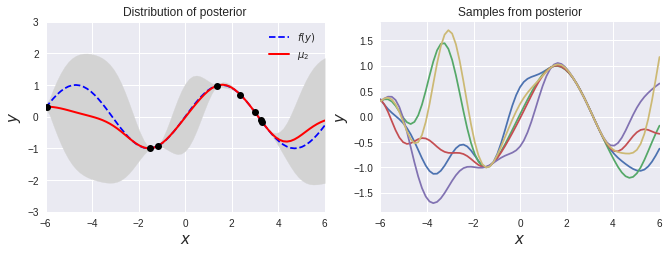

In [8]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,3.5))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f(X2), 'b--', label='$f(y)$')
ax1.fill_between(X2.flat, mean-2*s, mean+2*s, color='lightgrey')
ax1.plot(X2, mean, 'r-', lw=2, label='$\mu_2$')
ax1.plot(X1, y1, 'ko', linewidth=2)
ax1.set_xlabel('$x$', fontsize=15)
ax1.set_ylabel('$y$', fontsize=15)
ax1.set_title('Distribution of posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend(loc=1)
ax1.set_xlim([-6, 6])
# Plot some samples from this function
ax2.plot(X2, y2, '-')
ax2.set_xlabel('$x$', fontsize=15)
ax2.set_ylabel('$y$', fontsize=15)
ax2.set_title('Samples from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])

## Noisy observations

The predictions made above assume that the observations $f(X_1) = \mathbf{y}_1$ come from a noiseless distribution. We can make predictions from noisy observations $f(X_1) = \mathbf{y}_1 + \epsilon$, by modelling the noise $\epsilon$ as white Gaussian noise with variance $\sigma_\epsilon^2$.

This noise can be modelled by adding it to the covariance kernel of our observations:

$$
K_{11} = K(X_1,X_1) + \sigma_\epsilon^2 I
$$

Where $I$ is the identity matrix. Note that the noise only changes kernel values on the diagonal (white noise is independent).

The code below calculates the posterior distribution of the previous 8 samples with added noise. Note in the plots that the variance at the observations is no longer 0, and that the functions sampled don't necessarily have to go through these observational points anymore.

In [9]:
# Compute the posterior mean and covariance, and sample some functions for the noisy observations.
noise = 0.2 # The variance of the noise
# Add noise to the samples we sampled previously
y1_noise = y1 + noise * np.random.randn(n1)

def GP_noise(X1, y1, X2, kernel, noise):
    """
    Calculate the means and covariance matrix for the points X2 with unknown y2,
     based on the oberservations (y1, X1) with noise and the prior kernel.
    """
    # Get the noisy kernel of these samples and decompose in K11 = L11 * L11^T
    K11 = kernel(X1, X1) + noise * np.eye(n1)
    L11 = np.linalg.cholesky(K11)  
    # Compute K12/L11 to be use while getting the posterior mean and covariance
    K12 = kernel(X1, X2)
    LK12 = np.linalg.solve(L11, K12)  # K12 / L11
    # Compute the posterior mean
    Ly1 = np.linalg.solve(L11, y1)  # y1 / L11
    mu2 = LK12.T.dot(Ly1)
    # Compute the posterior covariance
    K22 = kernel(X2, X2)
    S21 = K22 - LK12.T.dot(LK12)
    return mu2, S21

mean_noise, cov_noise = GP_noise(X1, y1_noise, X2, kernel, noise)
# Compute the variance at the test points to be plotted
s = np.sqrt(np.diag(cov_noise))

# Draw some samples of the posterior
LS21 = np.linalg.cholesky(cov_noise + 1e-14*np.eye(n2))
y2 = mean.reshape(-1,1) + LS21.dot(np.random.normal(size=(n2,ny)))

(-6, 6)

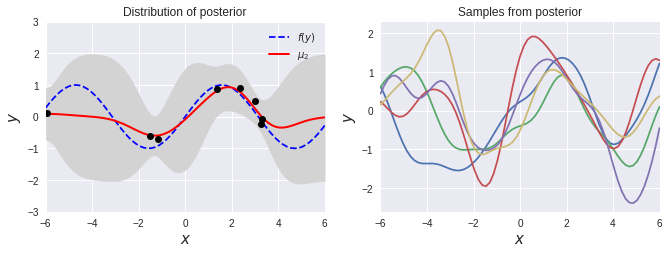

In [10]:
# Plot the postior distribution and some samples
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11,3.5))
# Plot the distribution of the function (mean, covariance)
ax1.plot(X2, f(X2), 'b--', label='$f(y)$')
ax1.fill_between(X2.flat, mean_noise-2*s, mean_noise+2*s, color='lightgrey')
ax1.plot(X2, mean_noise, 'r-', lw=2, label='$\mu_2$')
ax1.plot(X1, y1_noise, 'ko', linewidth=2)
ax1.set_xlabel('$x$', fontsize=15)
ax1.set_ylabel('$y$', fontsize=15)
ax1.set_title('Distribution of posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax1.legend(loc=1)
ax1.set_xlim([-6, 6])
# Plot some samples from this function
ax2.plot(X2, y2, '-')
ax2.set_xlabel('$x$', fontsize=15)
ax2.set_ylabel('$y$', fontsize=15)
ax2.set_title('Samples from posterior')
ax1.axis([domain[0], domain[1], -3, 3])
ax2.set_xlim([-6, 6])